In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

df = pd.read_parquet("../dataset.parquet")
print("Data size (amount of matches): ", len(df))
print("Columns: ", df.columns)

print(df.isna().sum())


Data size (amount of matches):  2089
Columns:  Index(['date', 'league', 'year', 'split', 'patch', 'game_order', 'gamelength',
       'team1_name', 'team2_name', 'team1_side', 'team2_side', 'team1_bans',
       'team2_bans', 'team1_result', 'team1_kills', 'team2_kills',
       'team1_dragons', 'team2_dragons', 'team1_elders', 'team2_elders',
       'team1_barons', 'team2_barons', 'team1_towers', 'team2_towers',
       'team1_damage_per_min', 'team2_damage_per_min', 'team1_wards_per_min',
       'team2_wards_per_min', 'team1_gold_per_min', 'team2_gold_per_min',
       'team1_gold_diff_at_10', 'team2_gold_diff_at_10', 'team1_killsat10',
       'team2_killsat10', 'team1_players', 'team2_players', 'team1_champions',
       'team2_champions', 'date_only', 'text', 'vid_name', 'embedding_masked',
       'embedding'],
      dtype='object')
date                        0
league                      0
year                        0
split                       0
patch                       0
game_or

In [2]:
# Functions definition: knn, display

def top_k_cosine_neighbors(df: pd.DataFrame, query_vec, k: int = 5, emb_col: str = "embedding"):
    """
    Returns indices of top-k most similar rows in df[emb_col] to query_vec using cosine similarity.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing an 'embedding' column (list or np.ndarray per row).
    query_vec
        The embedding vector to compare against, shape (D,).
    k : int
        Number of neighbors to return.
    emb_col : str
        Column name containing embeddings.

    Returns
    -------
    np.ndarray
        Array of DataFrame indices for top-k most similar rows (highest cosine sim).
    """

    # Stack embeddings into a matrix
    X = np.vstack(df[emb_col].to_numpy())  # shape (N, D)

    # Normalize both X and query for cosine similarity
    X_norm = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)
    q = query_vec / (np.linalg.norm(query_vec) + 1e-9)

    # Compute cosine similarity (dot product of normalized vectors)
    sims = X_norm @ q

    # Get top-k indices (descending order)
    topk_idx = np.argpartition(-sims, range(k))[:k]
    topk_idx = topk_idx[np.argsort(-sims[topk_idx])]

    return df.index[topk_idx]

def display_key_info_match(sample_match: pd.Series):
    print(sample_match.team1_name, sample_match.team2_name, sample_match.game_order, sample_match.date_only)
    print(sample_match.team1_champions, sample_match.team2_champions)
    print(sample_match.team1_players, sample_match.team2_players)

In [3]:
sample_match = df.iloc[-100]
sample_embedding = sample_match["embedding"]
display_key_info_match(sample_match)

Bilibili Gaming JD Gaming 2.0 2024-07-20
['Kennen', 'Maokai', 'Tristana', 'Miss Fortune', 'Rell'] ['Twisted Fate', 'Brand', 'Corki', 'Ezreal', 'Braum']
['Bin', 'Wei', 'Knight', 'Elk', 'ON'] ['sheer', 'Kanavi', 'Yagao', 'Ruler', 'MISSING']


In [4]:

closest = top_k_cosine_neighbors(df, sample_embedding, k=5)
closest

Index(['11303-11303_game_2', '11303-11303_game_1', '11303-11303_game_3',
       '10773-10773_game_1', '10390-10390_game_1'],
      dtype='object', name='gameid')

In [5]:
neighbor_idx = 3
closest = top_k_cosine_neighbors(df, sample_embedding, k=5)
close_neighbor_with_normal_embeddings = df.loc[closest[neighbor_idx]]
display_key_info_match(close_neighbor_with_normal_embeddings)

JD Gaming Bilibili Gaming 1.0 2024-02-24
['Twisted Fate', 'Xin Zhao', 'Hwei', 'Lucian', 'Milio'] ["K'Sante", 'Vi', 'Taliyah', 'Caitlyn', 'Lux']
['Flandre', 'Kanavi', 'Yagao', 'Ruler', 'MISSING'] ['Bin', 'Xun', 'Knight', 'Elk', 'ON']


In [6]:
closest = top_k_cosine_neighbors(df, sample_embedding, k=5, emb_col="embedding_masked")
close_neighbor_with_masked_embeddings = df.loc[closest[neighbor_idx]]
display_key_info_match(close_neighbor_with_masked_embeddings)


JD Gaming Top Esports 2.0 2024-04-07
["Rek'Sai", 'Wukong', 'Annie', 'Zeri', 'Rell'] ['Aatrox', 'Vi', 'Ahri', 'Varus', 'Alistar']
['Flandre', 'Kanavi', 'Yagao', 'Ruler', 'MISSING'] ['369', 'Tian', 'Creme', 'JackeyLove', 'Meiko']


In [33]:
from embedding_pca_analysis import  run_pca_and_attach, pca_full_markers_pipeline, pca_half_markers_pipeline
df_pca, X_pca, evr, pca = run_pca_and_attach(
    df,
    emb_col="embedding",
    n_components=2,
    random_state=42,
    x_col="pca_x",
    y_col="pca_y",
)

df_pca_masked, X_pca_masked, evr_masked, pca_masked = run_pca_and_attach(
    df,
    emb_col="embedding_masked",
    n_components=2,
    random_state=42,
    x_col="pca_x",
    y_col="pca_y",
)

Explained variance ratio (PC1, PC2): [0.06811813 0.05405758]
Total explained variance by first 2 PCs: 12.22%
Explained variance ratio (PC1, PC2): [0.06265826 0.04687334]
Total explained variance by first 2 PCs: 10.95%


## Embeddings exploration: team names

**Zde se mi zda, ze jak embeddingy sleduji tymy, tak je v 2D PCA lepsi separace a barvy jsou blize u sebe**

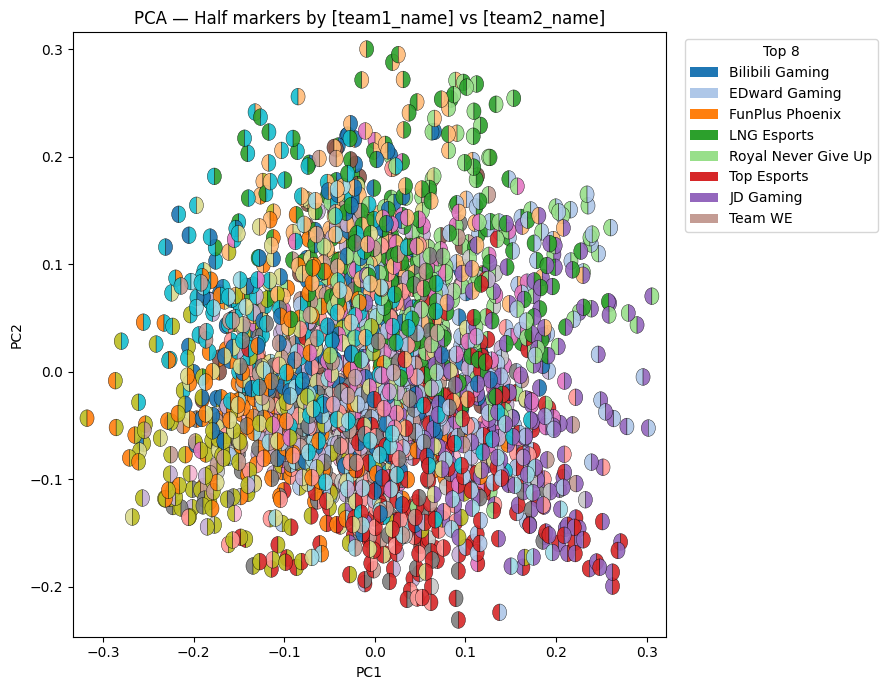

In [34]:
display(Markdown("## Embeddings exploration: team names"))
display(Markdown("**Zde se mi zda, ze jak embeddingy sleduji tymy, tak je v 2D PCA lepsi separace a barvy jsou blize u sebe**"))
pca_half_markers_pipeline(
    df_pca,
    left_col="team1_name",
    right_col="team2_name",
    legend_top_n=8,
    radius_factor=0.0125,
    cmap_name="tab20",
    save_path="pca_half_pies_by_teams.png",
    show=True,
);

**Barveno podle tymu, Masked.**

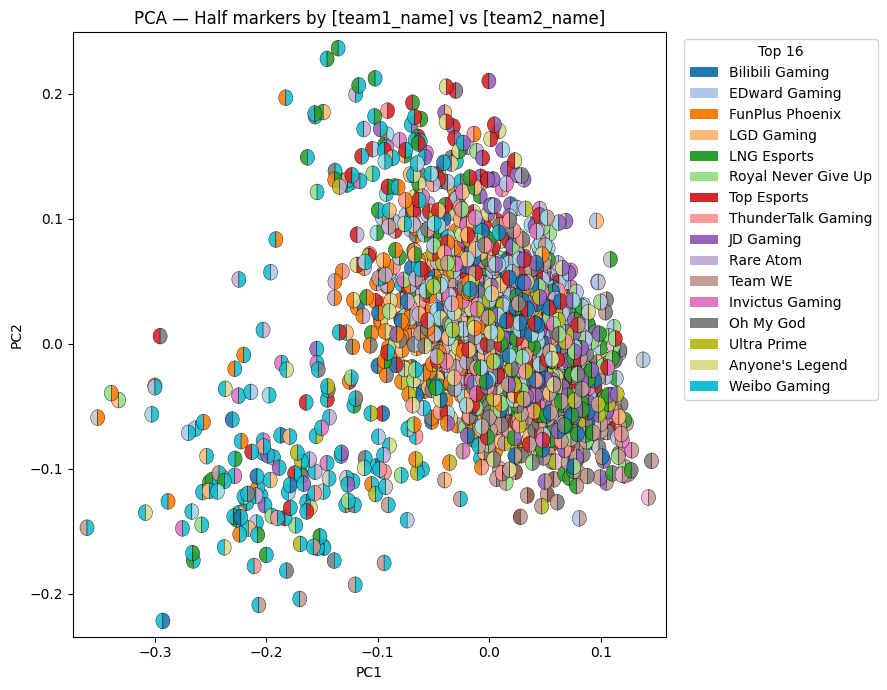

In [58]:
display(Markdown("**Barveno podle tymu, Masked.**"))
pca_half_markers_pipeline(
    df_pca_masked,
    left_col="team1_name",
    right_col="team2_name",
    legend_top_n=16,
    radius_factor=0.0125,
    cmap_name="tab20",
    save_path="pca_half_pies_by_teams.png",
    show=True,
);

## Embeddings exploration: gamelength

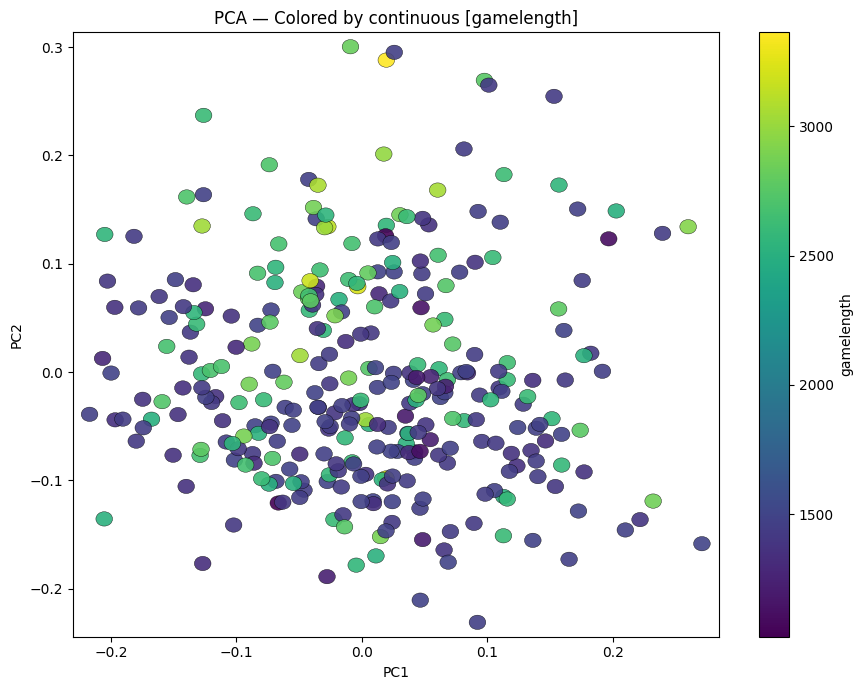

(<Figure size 900x700 with 2 Axes>,
 <Axes: title={'center': 'PCA — Colored by continuous [gamelength]'}, xlabel='PC1', ylabel='PC2'>)

In [49]:
display(Markdown("## Embeddings exploration: gamelength"))
df_pca["drag_diff"] = (df_pca["team1_dragons"] - df_pca["team2_dragons"])
df_pca_masked["drag_diff"] = (df_pca_masked["team1_dragons"] - df_pca_masked["team2_dragons"])

pca_full_markers_pipeline(
    df_pca[(df_pca.gamelength < 1500) | (df_pca.gamelength > 2500)],
    color_cols="gamelength",
    legend_top_n=10,
    radius_factor=0.0125,
    continuous=True,
    continuous_cmap="viridis",
    save_path="pca_by_gamelength_continuous.png",
    show=True,
)

KeyError: 'season'

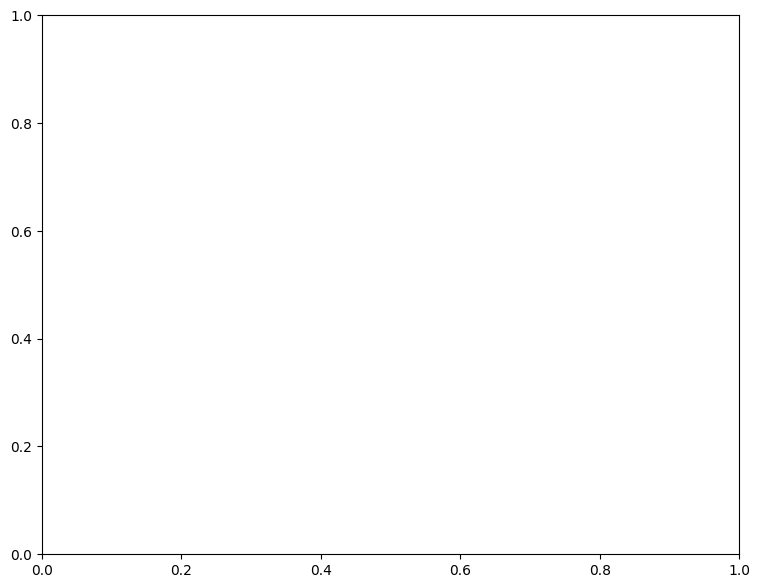

In [63]:
pca_full_markers_pipeline(
    df_pca_masked,
    color_cols="season",
    legend_top_n=10,
    radius_factor=0.0125,
    continuous=True,
    continuous_cmap="viridis",
    save_path="pca_by_gamelength_continuous.png",
    show=True,
)


## Embeddings exploration: amount of towers destroyed

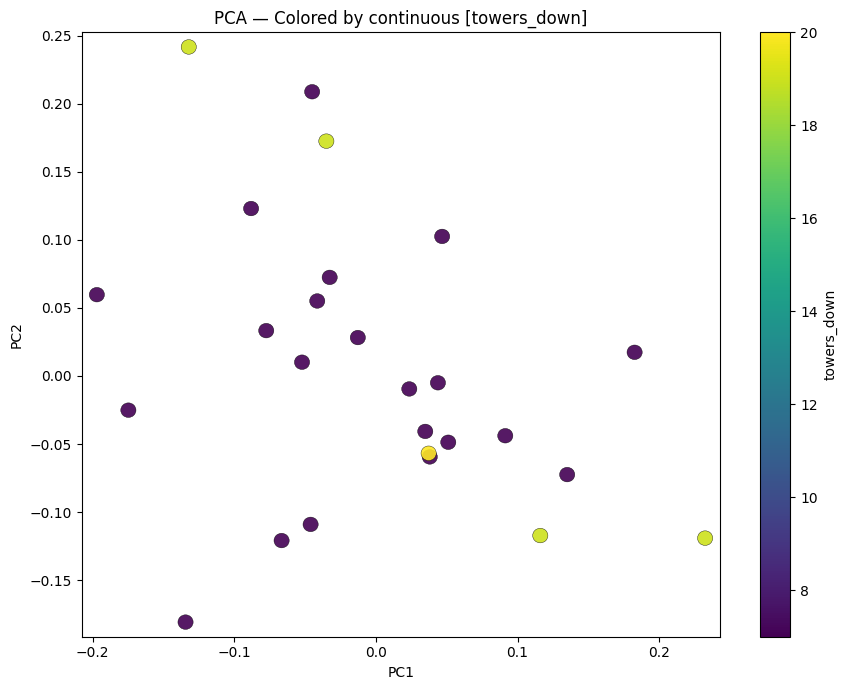

(<Figure size 900x700 with 2 Axes>,
 <Axes: title={'center': 'PCA — Colored by continuous [towers_down]'}, xlabel='PC1', ylabel='PC2'>)

In [61]:
display(Markdown("## Embeddings exploration: amount of towers destroyed"))
df_pca["towers_down"] = (df_pca["team1_towers"] + df_pca["team2_towers"])
df_pca_masked["towers_down"] = (df_pca_masked["team1_towers"] + df_pca_masked["team2_towers"])
pca_full_markers_pipeline(
    df_pca[(df_pca.towers_down < 8) | (df_pca.towers_down > 18)],
    color_cols="towers_down",
    legend_top_n=10,
    radius_factor=0.0125,
    continuous=True,
    continuous_cmap="viridis",
    save_path="pca_by_gamelength_continuous.png",
    show=True,
)


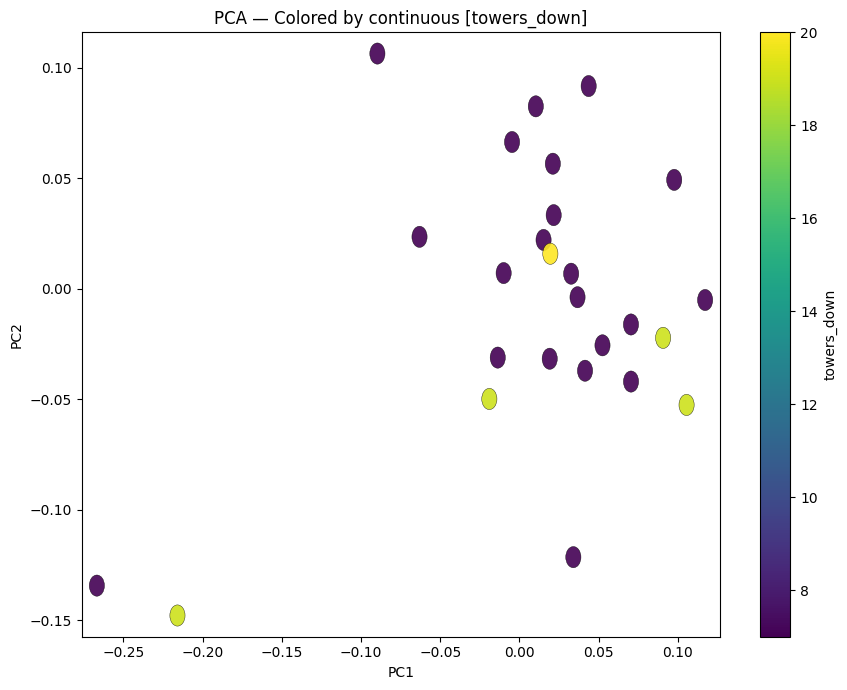

(<Figure size 900x700 with 2 Axes>,
 <Axes: title={'center': 'PCA — Colored by continuous [towers_down]'}, xlabel='PC1', ylabel='PC2'>)

In [62]:
pca_full_markers_pipeline(
    df_pca_masked[(df_pca_masked.towers_down < 8) | (df_pca_masked.towers_down > 18)],
    color_cols="towers_down",
    legend_top_n=10,
    radius_factor=0.0125,
    continuous=True,
    continuous_cmap="viridis",
    save_path="pca_by_gamelength_continuous.png",
    show=True,
)